In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import pandas as pd

Predicting winning 2025 Baseball Team
- 
We compiled data from https://retrosheet.org/downloads/csvdownloads.html. 

### Hypothesis
Given two teams statistics and date they played, we can predict who won that specific match. <br><br>
Alternative hypotheses could be if weather, time of day effect, location of playing affect a teams outcome. Following, we can also see if any interal statistics of a team such as batter appearances or stolen bases influence a match's outcome or not. 

Limitations of our model: It cannot predict winners in early games due to a lack of data around that time. Although we can incoporate data from last year, many other factors such as team swaps and new playing strategies can affect data from season to season may from this.

In [2]:
gameInfo = pd.read_csv("data/2025gameinfo.csv")
teamStats = pd.read_csv("data/2025teamstats.csv")

In [3]:
gameInfo.head()

,gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,...,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season
0,CHN202503180,LAN,CHN,TOK01,20250318,0,7:10PM,night,9,2.0,...,4,1,LAN,CHN,y,both,y,y,y,2025
1,CHN202503190,LAN,CHN,TOK01,20250319,0,7:10PM,night,9,2.0,...,6,3,LAN,CHN,y,both,y,y,y,2025
2,ARI202503270,CHN,ARI,PHO01,20250327,0,7:10PM,night,9,2.0,...,10,6,CHN,ARI,y,both,y,y,y,2025
3,CHA202503270,ANA,CHA,CHI12,20250327,0,3:10PM,day,9,2.0,...,1,8,CHA,ANA,y,both,y,y,y,2025
4,CIN202503270,SFN,CIN,CIN09,20250327,0,4:10PM,day,9,2.0,...,6,4,SFN,CIN,y,both,y,y,y,2025


In [4]:
teamStats.head()

,gid,team,inn1,inn2,inn3,inn4,inn5,inn6,inn7,inn8,...,number,site,vishome,opp,win,loss,tie,gametype,box,pbp
0,CHN202503180,LAN,0,0,0,0,3,0.0,0.0,0.0,...,0,TOK01,v,CHN,1,0,0,regular,y,y
1,CHN202503180,CHN,0,1,0,0,0,0.0,0.0,0.0,...,0,TOK01,h,LAN,0,1,0,regular,y,y
2,CHN202503190,LAN,0,2,1,2,1,0.0,0.0,0.0,...,0,TOK01,v,CHN,1,0,0,regular,y,y
3,CHN202503190,CHN,0,0,1,1,1,0.0,0.0,0.0,...,0,TOK01,h,LAN,0,1,0,regular,y,y
4,ARI202503270,CHN,0,3,0,1,3,1.0,0.0,0.0,...,0,PHO01,v,ARI,1,0,0,regular,y,y


To preprocess our data, we are only concerned on the following gametypes: Regular, Wild Card, Divison Series, Leagure Champion Series, and World Series. We want to omit Allstars game. 

In [5]:
# drop all stars
teamStats = teamStats.drop(teamStats[teamStats['gametype'] == 'allstar'].index)
teamStats.head()

,gid,team,inn1,inn2,inn3,inn4,inn5,inn6,inn7,inn8,...,number,site,vishome,opp,win,loss,tie,gametype,box,pbp
0,CHN202503180,LAN,0,0,0,0,3,0.0,0.0,0.0,...,0,TOK01,v,CHN,1,0,0,regular,y,y
1,CHN202503180,CHN,0,1,0,0,0,0.0,0.0,0.0,...,0,TOK01,h,LAN,0,1,0,regular,y,y
2,CHN202503190,LAN,0,2,1,2,1,0.0,0.0,0.0,...,0,TOK01,v,CHN,1,0,0,regular,y,y
3,CHN202503190,CHN,0,0,1,1,1,0.0,0.0,0.0,...,0,TOK01,h,LAN,0,1,0,regular,y,y
4,ARI202503270,CHN,0,3,0,1,3,1.0,0.0,0.0,...,0,PHO01,v,ARI,1,0,0,regular,y,y


Now we want to preprocess our data. List of features we want to extract, create, and make are: finding team statistics leading up to game point and truncating win/loss/tie into one column of a Y output.

Here is a key to all the features we are going to be finding:
- 
- b_pa: plate appearances
- b_ab: At bats
- b_r: Runs scored
- b_h: Hits
- b_d: Doubles
- b_t: Triples
- b_hr: Home runs
- b_w: Walks
- b_k: Strikeouts
- b_sb: Stolen bases
- b_cs: Caught stealing
- b_gdp: Grounded into double play
- p_bfp: Batters faced
- p_h: Hits allowed
- p_d: Doubles allowed
- p_t: Triples allowed
- p_hr: Home runs allowed
- p_r: Runs allowed
- p_w: Walks allowed
- p_k: Strikeouts
- p_hbp: Hit batters
- p_sb: Stolen bases allowed
- p_cs: Runners caught stealing
- d_po: Putouts
- d_a: Assists
- d_dp: Double plays turned
- d_tp: Triple plays turned
- d_sb: Stolen bases allowed (catcher)

In [6]:
# helper function
def findFeatures(key_features, row):
    teamLeadingStats = teamStats.loc[((teamStats['date'] < row['date']) & (teamStats['team'] == row['team']))]
    teamFeatures = dict.fromkeys(key_features)

    for feature in key_features:
        feature_total_sum = 0
        count = 0

        for _, row1 in teamLeadingStats.iterrows():
            count += 1
            feature_total_sum += row1[feature]

        if(count == 0):
            teamFeatures[feature] = 0
        else:
            teamFeatures[feature] = (feature_total_sum / count)
    
    return teamFeatures

In [7]:
key_features = ['b_pa', 'b_ab', 'b_r', 'b_h', 'b_d', 'b_t', 'b_hr', 'b_w', 'b_k', 'b_sb' , 'b_gdp', 'p_bfp', 'p_h', 'p_d', 'p_t', 'p_hr', 'p_r', 'p_w', 'p_k', 'p_hbp', 'p_sb', 'p_cs', 'd_a', 'd_dp', 'd_tp', 'd_sb']
polished_teamStats_df = pd.DataFrame(columns=['date', 'team'] + key_features)

for gameId in gameInfo['gid']:
    teams = teamStats.loc[(teamStats['gid'] == gameId)]

    for _, row in teams.iterrows():
        teamFeatures = findFeatures(key_features, row)
        teamFeatures['date'] = row['date']
        teamFeatures['team'] = row['team']

        polished_teamStats_df.loc[len(polished_teamStats_df)] = teamFeatures

polished_teamStats_df.head()

,date,team,b_pa,b_ab,b_r,b_h,b_d,b_t,b_hr,b_w,...,p_r,p_w,p_k,p_hbp,p_sb,p_cs,d_a,d_dp,d_tp,d_sb
0,20250318,LAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20250318,CHN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20250319,LAN,42.0,34.0,4.0,7.0,2.0,0.0,0.0,8.0,...,1.0,1.0,9.0,1.0,1.0,0.0,8.0,0.0,0.0,1.0
3,20250319,CHN,32.0,30.0,1.0,3.0,1.0,0.0,0.0,1.0,...,4.0,8.0,9.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
4,20250327,CHN,36.5,32.0,2.0,5.5,1.5,0.0,0.0,4.0,...,5.0,7.5,9.0,0.0,0.0,0.0,10.5,1.5,0.0,0.0


In [8]:
# write to CSV
polished_teamStats_df["win"] = teamStats["win"]
polished_teamStats_df.to_csv('polished_teamStats.csv', index=False)

In [9]:
# polished dataframe
polished_teamStats_df = pd.read_csv("polished_teamStats.csv")

# filter it such that it removes first month of games
polished_teamStats_df = polished_teamStats_df[polished_teamStats_df['date'].astype(int) >= 20250418]


Plotting Data:<br>
1. First visualization shows the number of homeruns versus the number of strikeouts with red signifying wins and blue signifying losses

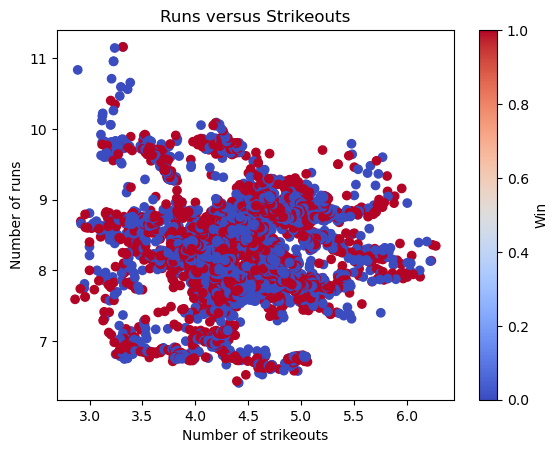

In [10]:
plt.scatter(x = polished_teamStats_df["b_r"].values, y = polished_teamStats_df["b_k"], c = polished_teamStats_df["win"].values, cmap='coolwarm')
plt.xlabel("Number of strikeouts")
plt.ylabel("Number of runs")
plt.title("Runs versus Strikeouts")
plt.colorbar(label="Win")
plt.show()

/var/folders/hp/4ybyp3g956n7ppxk8881bj040000gn/T/ipykernel_77603/4147093475.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([runs_wins, run_losses], labels=["Wins", "Losses"])


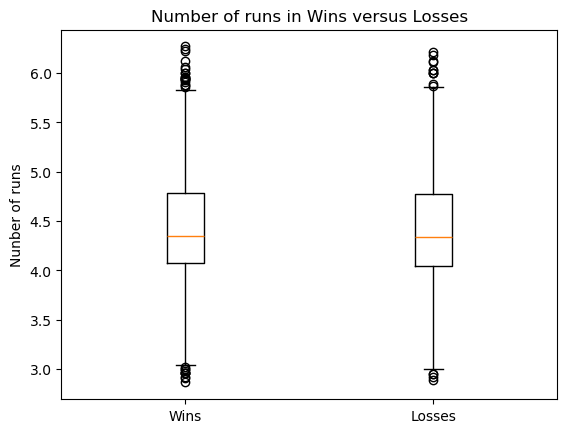

In [11]:
runs_wins = polished_teamStats_df["b_r"][polished_teamStats_df["win"] == 1]
run_losses = polished_teamStats_df["b_r"][polished_teamStats_df["win"] == 0]

plt.boxplot([runs_wins, run_losses], labels=["Wins", "Losses"])
plt.ylabel("Nunber of runs")
plt.title("Number of runs in Wins versus Losses")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# we want to preprocess our data such that it cuts of ALL the dates before 4/18/2025: Months Worth of Data
gameInfo = gameInfo[gameInfo['date'].astype(int) >= 20250418]

# we want to split it now!
X_train, X_test, Y_train, Y_test = train_test_split(gameInfo[["visteam","hometeam","date"]],gameInfo["wteam"], random_state=42)

In [13]:
# Helper function
def translateX(team_ids, dates, polished_df):
    """
    Maps each (team, date) pair to exactly one stats row.
    Always returns a 2D NumPy array with consistent shape.
    """
    stat_cols = polished_df.drop(columns=["team", "date"]).columns
    zero_row = np.zeros(len(stat_cols))

    rows = []
    for team, date in zip(team_ids, dates):        
        mask = (polished_df["team"] == team) & (polished_df["date"] < date) 
        subset = polished_df.loc[mask]

        if subset.empty:
            rows.append(zero_row)
            continue

        idx = subset["date"].idxmax()
        latest_row = polished_df.loc[idx, stat_cols].values
        rows.append(latest_row)
    
    return rows

We choose XGBoost and RandomForestClassifier because both models fit with classification especially given large amounts of input data.

In [14]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# initializing with random hyperparameters
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.2, max_depth=3, random_state=42)

In [15]:
def train(X, Y, model):
    '''We want to translate X and Y into actual data points that we can have our data train on'''
    polsihed_team1 = translateX(X["visteam"], X ["date"], polished_teamStats_df)
    polished_team2 = translateX(X["hometeam"], X["date"], polished_teamStats_df)

    Y_binary = (Y != X["hometeam"]).astype(int)

    diff = np.array(polsihed_team1) - np.array(polished_team2)
    model.fit(diff, Y_binary)

In [16]:
train(X_train, Y_train, rf_model)
rf_model

RandomForestClassifier(random_state=42)

In [17]:
train(X_train, Y_train, xgb_model)
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

Now that we have trained it, lets test its accuracy. 

In [18]:
from sklearn.metrics import accuracy_score

def test(X, Y, model):
    polsihed_team1 = translateX(X["visteam"], X ["date"], polished_teamStats_df)
    polished_team2 = translateX(X["hometeam"], X["date"], polished_teamStats_df)

    Y_binary = (Y != X["hometeam"]).astype(int)

    diff = np.array(polsihed_team1) - np.array(polished_team2)
    y = model.predict(diff)

    return accuracy_score(y, Y_binary)

In [19]:
print("Accuracy of RandomForest:", test(X_test, Y_test, rf_model))
print("Accuracy of XGBoost:", test(X_test, Y_test, xgb_model))

Accuracy of RandomForest: 0.517304189435337
Accuracy of XGBoost: 0.4918032786885246


Now we want to find the most optimal hyperparameters. To do this we use the builtin grid search and randomized search function given to us by the Sklearn library. 

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [21]:
x_train_team1 = translateX(X_train["visteam"], X_train["date"], polished_teamStats_df)
x_train_team2 = translateX(X_train["hometeam"], X_train["date"], polished_teamStats_df)

Y_binary_train = (Y_train != X_train["hometeam"]).astype(int)

diff_train = np.array(x_train_team1) - np.array(x_train_team2)

In [29]:
# testing everything for Random Forest tree
param_grid_rf = {
        'n_estimators':  list(range(175, 226,5)),
        'max_depth': [ 3, 4, 5],
        'min_samples_split': [1,2],
        'max_features': ['sqrt', 'log2']
    }

randomforest_cv = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1)

randomforest_cv.fit(diff_train, Y_binary_train)

print("Tuned Random Forest Classifier Parameters: {}".format(randomforest_cv.best_params_))
print("Best score is {}".format(randomforest_cv.best_score_))

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
330 fits failed out of a total of 660.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
330 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 436, in _validate_para

Tuned Random Forest Classifier Parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best score is 0.5544072948328267


In [30]:
# testing randomly for xgb
param_grid_xgb = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(1, 10),          
    'learning_rate': uniform(0.01, 0.3),    
    'subsample': uniform(0.5, 0.5),         
    'colsample_bytree': uniform(0.5, 0.5),  
    'min_child_weight': randint(1, 10),
}

xgb_model = xgb.XGBClassifier(
    tree_method="exact",
    n_jobs = 2,
)

xgb_rs = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions= param_grid_xgb,
    n_iter=100,
    cv=5,
    verbose=1,
    n_jobs=-1  
)

xgb_rs.fit(diff_train, Y_binary_train)

print("Tuned XGBoost Parameters: {}".format(xgb_rs.best_params_))
print("Best score is {}".format(xgb_rs.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuned XGBoost Parameters: {'colsample_bytree': np.float64(0.9732103931334486), 'learning_rate': np.float64(0.05390270414175724), 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 123, 'subsample': np.float64(0.5582942930432997)}
Best score is 0.5556231003039513


Now we have the best parameters for our two models, lets train and show there scores.

In [34]:
best_xgb = xgb.XGBClassifier(**xgb_rs.best_params_)
best_rf = RandomForestClassifier(**randomforest_cv.best_params_)

train(X_train, Y_train, best_xgb)
train(X_train, Y_train, best_rf)

print(f"Now our best accuracy for our XGBoost is: {test(X_test, Y_test, best_xgb) * 100}%")
print(f"Now our best accuracy for our Random Forest Classifier is: {test(X_test, Y_test, best_rf) * 100}%")


Now our best accuracy for our XGBoost is: 51.36612021857923%
Now our best accuracy for our Random Forest Classifier is: 53.18761384335154%


Exception ignored in: <function ResourceTracker.__del__ at 0x106e65bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1068adbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1028b1bc0>
Traceback (most recent call last

## Reflection:
Comparing Random Forest Model to XGBoost, we found that both models were only slightly better than guessing with Random Forest Classifier at 53% accuracy and XGBoost at 51%. We think the problem lies within both the lack of data and also complex layerings of baseball with many factors including player peformance, fan interferance, and enviroment also potentially obstructing a games outcome. We found the ideal parameters for Random Forest model through grid search and XGBoost through randomisized search. Given that our game data was only on 2025 and that baseball is a sport of high unpredictability, our models did a much more capable job than just simply guessing. In hindsight, we would like to understand our data more so that we can peform enhanced feature extraction as well as understand how to visualize baseball data better. 